# 1. Setup

In [1]:
import pickle
from time import time

from lightgbm import LGBMRegressor, plot_tree
from matplotlib.patches import Patch
import plotly.express as px
from scipy.stats import entropy
import shap
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import sklearn as skl

from utils import *

# 2. Load data and models

## 2.1. Data

In [2]:
trips = pd.read_parquet('../data/nhts/trips.parquet').disp()

737,685 rows x 31 cols; Memory: 51.4 MiB


RawDuration   Duration   Distance      Speed LogDistance TripWeight  \
      <int64>  <float64>  <float64>  <float64>   <float64>  <float64>   
0          15  15.591037   8.439379  32.477809    3.926362   0.006319   

         Mode   HomeBased     Purpose     VehType  ...     HomeOwn  \
   <category>  <category>  <category>  <category>  ...  <category>   
0       Drive         Yes      Social         Car  ...         Own   

      MSAKind      UrbanO      UrbanD PopDensityO PopDensityD HouseDensityO  \
   <category>  <category>  <category>  <category>  <category>    <category>   
0       Small    Suburban    Suburban         Mid         Low           Mid   

  HouseDensityD EmpDensityO EmpDensityD  
     <category>  <category>  <category>  
0           Low         Mid         Low  

[2 rows x 31 columns]

In [3]:
feature_grps = pd.concat([
    Pdf(D(feature=trips.loc[:, start: end].columns)).assign(group=grp) 
    for grp, (start, end) in {
        'Trip': ('Mode', 'StartTime'),
        'SES': ('Age', 'HomeOwn'),
        'OD': ('MSAKind', 'EmpDensityD')
    }.items()]).reset_index(drop=1).disp(3)

25 rows x 2 cols; Memory: 0.0 MiB


feature     group
    <object>  <object>
0       Mode      Trip
1  HomeBased      Trip
2    Purpose      Trip

In [4]:
ds_full = {trg: Dataset(trips, trg, rng, 0.3) for trg, rng in 
           D(LogDistance=(2, 5), Duration=(0, 90)).items()}

## 2.2. Model

In [5]:
models = load_pickle('../data/nhts/selected_models.pkl')
models['Duration']

LGBMRegressor(force_row_wise=True, learning_rate=0.05, n_jobs=-1, verbosity=0)

## 2.3. Interactive distributions

In [6]:
def plot_distr_vars(data=trips, width=1600, height=500):
    res = []
    for measure, vmin, vmax in [('Duration', 0, 90), ('LogDistance', 1, 6), ('Speed', 0, 80)]:
        for var in data.select_dtypes(CAT):
            for cat, df in data.groupby(var):
                y, x = np.histogram(df[measure].clip(vmin, vmax), 
                                    bins=100, weights=df.TripWeight)
                y = (y / y.sum()).cumsum()
                # y = y / y.sum()
                res.append(Pdf(D(value=x[1:], density=y))
                           .assign(var=var, cat=cat, measure=measure))
    res = pd.concat(res).reset_index(drop=1)
    fig = px.line(res, x='value', y='density', color='var', facet_col='measure',
                  width=width, height=height, hover_name='cat', hover_data=['cat'],
                  labels=D(density='Cumulative probability density', var='Factor'))
    fig.update_layout(hoverlabel=D(bgcolor='white', font_size=16),
                      font=D(family='Arial', size=18))
    fig.for_each_xaxis(lambda x: x.update(matches=None))
    fig.show()

plot_distr_vars() # t=0:13

# 3. Select features

## 3.1. Compute SHAP values

### 3.1.1. For factor levels

In [7]:
def get_shap(models, datasets, seed=1234, overwrite=False):
    outpath = Path('../data/nhts/shap_levels.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    res = []
    for target in tqdm(['LogDistance', 'Duration']):
        ds, model = datasets[target], models[target]
        explainer = shap.TreeExplainer(model, seed=seed)
        shaps = explainer(ds.X).values
        df = Pdf(shaps, columns=ds.X.columns).astype(np.float32)
        df = df.rename_axis('row_id').reset_index().astype(D(row_id=np.int32))
        df.insert(0, 'target', target)
        res.append(df)
    res = pd.concat(res).reset_index(drop=1).astype(D(target=CAT))
    res.to_parquet(mkfile(outpath))
    return res

shap_level = get_shap(models, ds_full, overwrite=0).disp() # t=1:18

1,475,370 rows x 76 cols; Memory: 423.5 MiB


target   row_id Mode__Drive Mode__Transit Mode__Walk Mode__Bike  \
    <category>  <int32>   <float32>     <float32>  <float32>  <float32>   
0  LogDistance        0    0.000192     -0.000338   0.033338   0.001037   

  HomeBased__No HomeBased__Yes Purpose__Work Purpose__Shopping  ...  \
      <float32>      <float32>     <float32>         <float32>  ...   
0      0.008088       0.002625      -0.01037          0.005215  ...   

  HouseDensityO__High HouseDensityD__Low HouseDensityD__Mid  \
            <float32>          <float32>          <float32>   
0            0.000208           0.026291           0.000172   

  HouseDensityD__High EmpDensityO__Low EmpDensityO__Mid EmpDensityO__High  \
            <float32>        <float32>        <float32>         <float32>   
0           -0.000063         0.000229         0.000482         -0.000335   

  EmpDensityD__Low EmpDensityD__Mid EmpDensityD__High  
         <float32>        <float32>         <float32>  
0        -0.000019         0.000414          0.000118  

[2 rows x 76 columns]

### 3.1.2. For features

In [8]:
def get_feature_contrib(shap_level, features=feature_grps.feature):
    shap_feature = shap_level[['target', 'row_id']]
    for feat in features:
        col = np.abs(shap_level.filter(like=feat + '__')).sum(1).rename(feat)
        shap_feature = pd.concat([shap_feature, col], axis=1)
    res = ((shap_feature.drop(columns='row_id')
            .groupby('target').apply(sum) / (len(shap_feature) / 2))
           .reset_index().melt('target', var_name='feature', value_name='abs_shap'))
    return res

shap_feature_contrib = get_feature_contrib(shap_level).disp()

50 rows x 3 cols; Memory: 0.0 MiB


target   feature   abs_shap
   <category>  <object>  <float32>
0    Duration      Mode   0.013345

## 3.2. Feature & level contributions

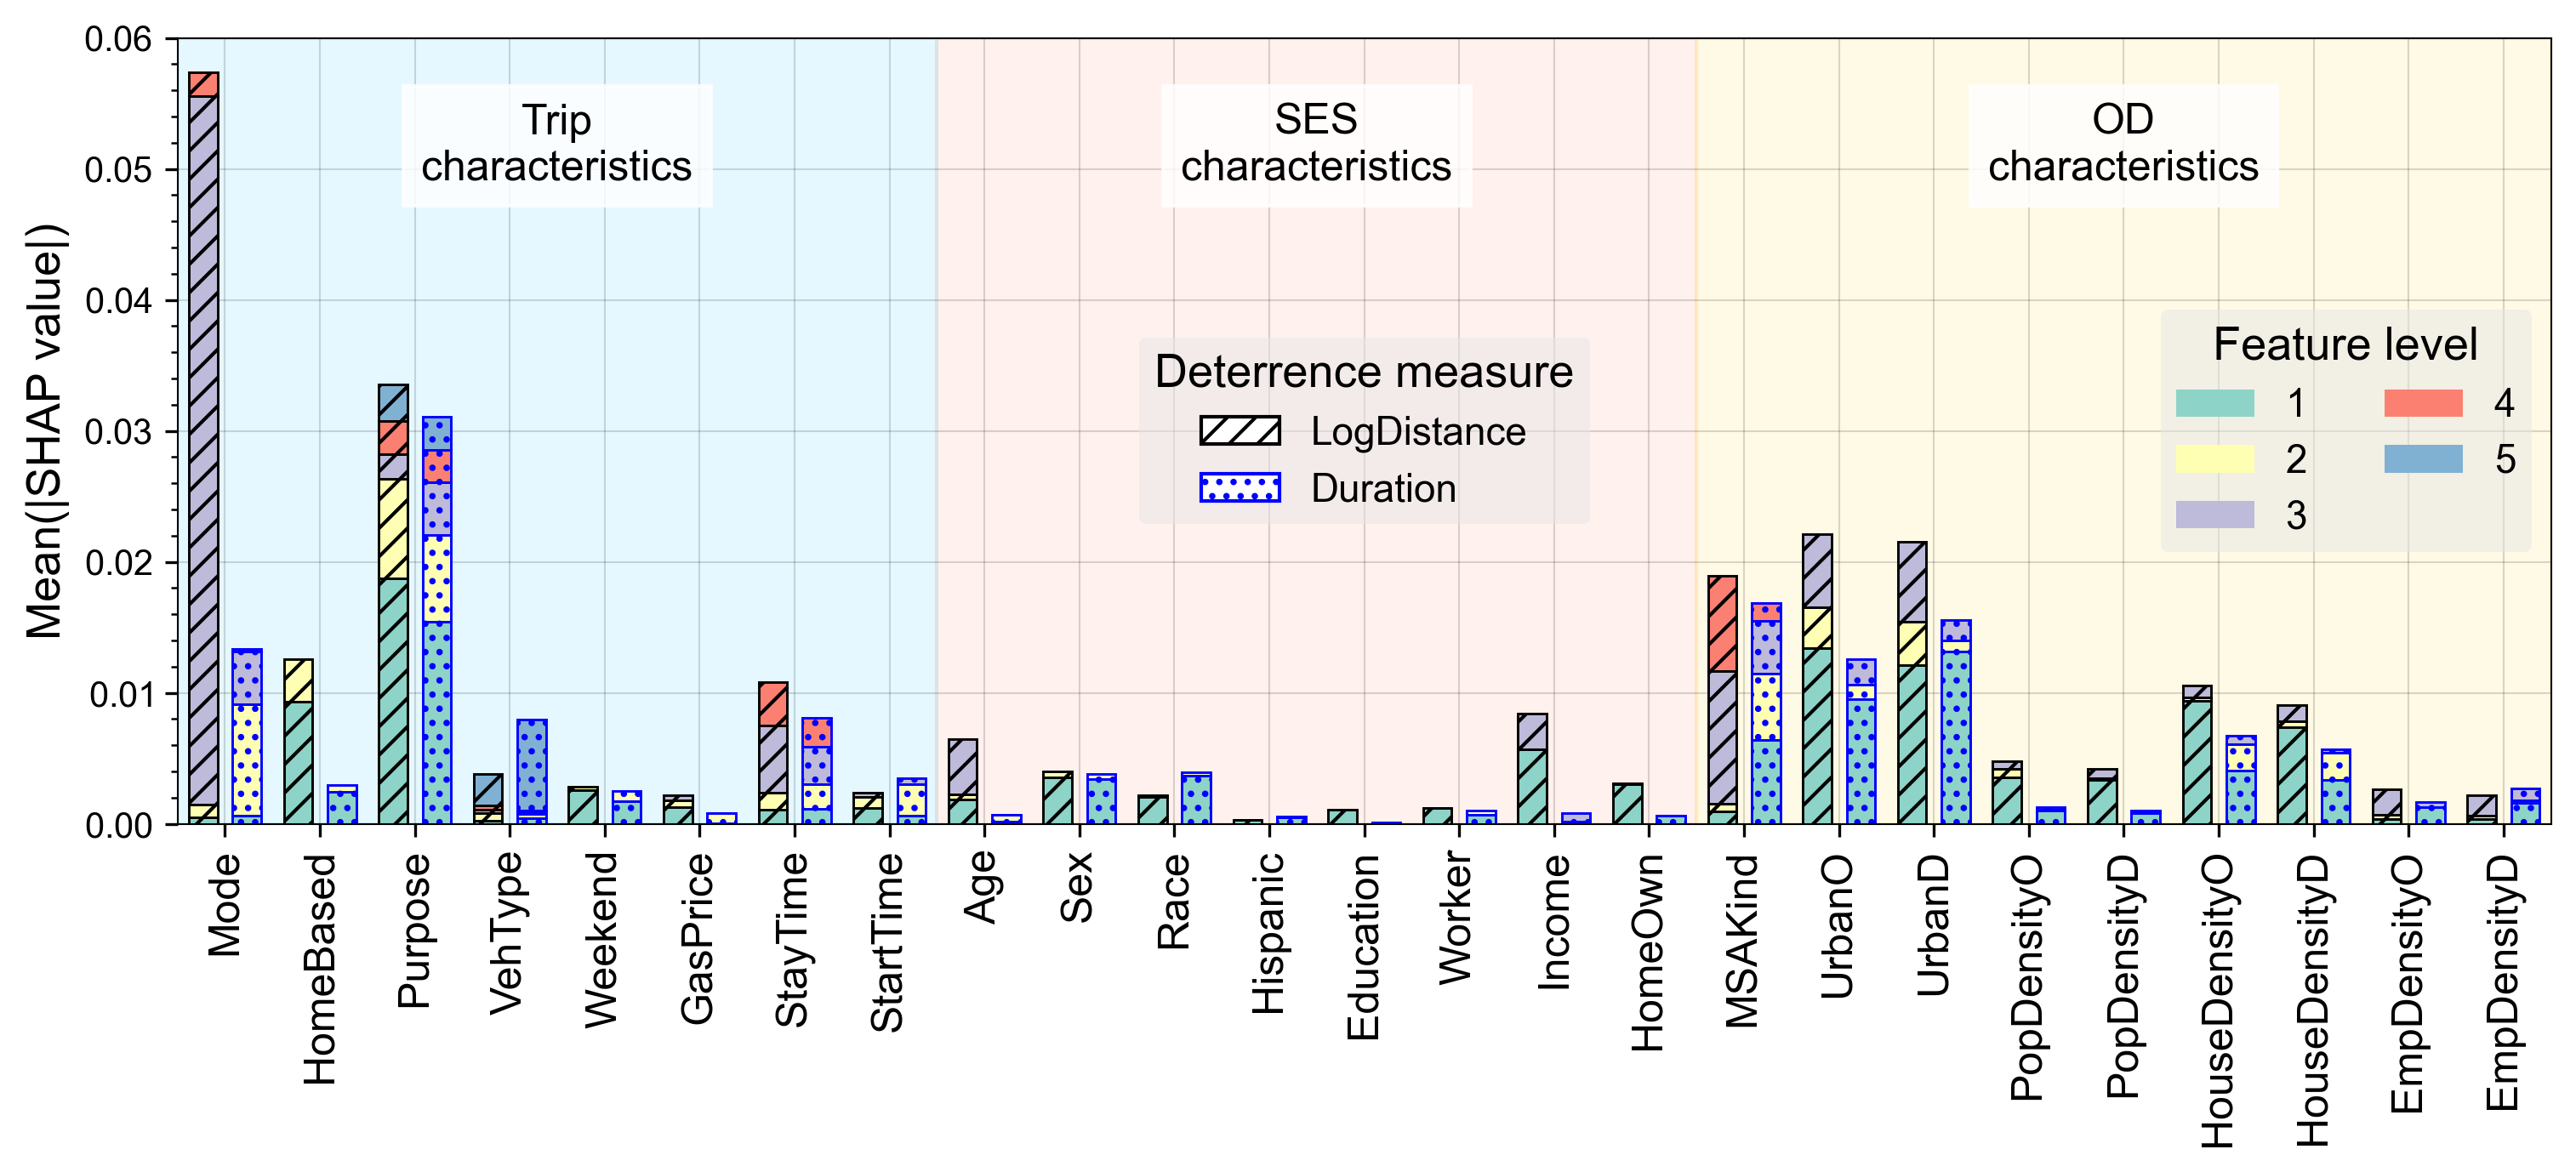

In [9]:
def fig_feature_selection2(shaps, feats=feature_grps, dx=0.08, width=0.3,
                           size=(12, 4), dpi=150, cmap='Set3'):
    sh = np.abs(shaps.drop(columns='row_id').set_index('target'))
    sh = sh.groupby('target').mean(0).reset_index().melt('target')
    sh['feature'] = sh.variable.str.split('__').str[0]
    sh['level'] = sh.variable.str.split('__').str[1]
    grps = feats.groupby('group', sort=0).size().rename('width').reset_index()
    grps['start'] = grps.width.cumsum().shift().fillna(0)
    ax = pplot(size=size, dpi=dpi, ylab='Mean(|SHAP value|)', xminor=0)
    targets = [('LogDistance', 'k', '///'), ('Duration', 'b', '...')]
    for i, (trg, color, hatch) in enumerate(targets):
        for j, feat in enumerate(feats.feature):
            df = sh.query(f'target=="{trg}" & feature=="{feat}"').copy()
            df['bottom'] = df.value.cumsum().shift().fillna(0)
            df['color'] = sns.color_palette(cmap, len(df))
            df.color = df.color.apply(mpl.colors.to_hex)
            for _, r in df.iterrows():
                x = j + (2 * i - 1) * (dx + width / 2) - width / 2
                ax.add_artist(mpl.patches.Rectangle(
                    (x, r.bottom), width, r.value,
                    color=r.color, ec=color, lw=0.7, hatch=hatch))
            # ax.bar(j + dx * (i - 0.5), df.value, width, 0,
            #        color=df.color, ec=color, lw=0.7, hatch=hatch)
    ax.set_xticks(range(len(feats)), feats.feature, rotation=90, fontsize=12)
    ax.set_xlim(-0.5, len(feats) - 0.5)
    ax.set_ylim(0, 0.06)
    for (_, r), color in zip(grps.iterrows(), ['deepskyblue', 'coral', 'gold']):
        ax.axvspan(r.start - 0.5, r.start + r.width - 0.5, color=color, alpha=0.1, zorder=-1)
        ax.text(r.start - 0.5 + r.width / 2, 0.055, f'{r.group}\ncharacteristics',
                color='k', ha='center', va='top', fontsize=12,
                bbox=D(pad=5, color='w', alpha=0.8))
    leg1 = plt.legend(loc='center', title='Deterrence measure', handles=[
        mpl.patches.Patch(fc='w', ec=c, hatch=h, label=l) for l, c, h in targets])
    plt.gca().add_artist(leg1)
    max_levels = sh.groupby(['target', 'feature']).size().max()
    colors = sns.color_palette(cmap, max_levels)
    labels = [str(i + 1) for i in range(len(colors))]
    plt.legend(loc='center right', ncol=2, title='Feature level', handles=[
        mpl.patches.Patch(fc=c, ec='none', label=l) for c, l in zip(colors, labels)])
    imsave('SHAP values by feature and level', root='../fig/nhts')

fig_feature_selection2(shap_level, dpi=300) # t=0:04

## PCA clustering groups

In [25]:
feature_grps

feature group
0            Mode  Trip
1       HomeBased  Trip
2         Purpose  Trip
3         VehType  Trip
4         Weekend  Trip
5        GasPrice  Trip
6        StayTime  Trip
7       StartTime  Trip
8             Age   SES
9             Sex   SES
10           Race   SES
11       Hispanic   SES
12      Education   SES
13         Worker   SES
14         Income   SES
15        HomeOwn   SES
16        MSAKind    OD
17         UrbanO    OD
18         UrbanD    OD
19    PopDensityO    OD
20    PopDensityD    OD
21  HouseDensityO    OD
22  HouseDensityD    OD
23    EmpDensityO    OD
24    EmpDensityD    OD

In [26]:
def fig_pca_clust(shaps=shap_level, trips=trips, groups=feature_grps,
                  cmap='terrain', size=(12, 5), dpi=150):
    return groups.query('group=="OD"').feature
    cols = D(OD='UrbanO UrbanD PopDensityO PopDensityD HouseDensityO HouseDensityD EmpDensityO EmpDensityD'.split(),
             SES='Age Sex Race Hispanic Education Worker INcome Homeown'.split())
    return trips
    df, ncol = trips[cols], len(cols)
    cols = list(pd.get_dummies(df, prefix_sep='__').columns)
    fig, axes = plt.subplots(2, 2, figsize=size, dpi=dpi,
                             gridspec_kw=D(width_ratios=[1, 10]))
    for i, (target, ncomp) in enumerate(ncomps.items()):
        X = shaps.query(f'target=="{target}"')[cols]
        pca = PCA(ncol).fit(X)
        ## Panel A: Explained variance ratios
        contrib = pca.explained_variance_ratio_ * 100
        df = Pdf(D(val=contrib))
        ax = pplot(axes[i, 0], ylab='% explained variance')
        colors = sns.color_palette(cmap, ncol)
        ax = df.T.plot(ax=ax, kind='bar', stacked=True, color=colors, alpha=0.8)
        df['pos'] = (df.val.cumsum() + df.val.cumsum().shift().fillna(0)) / 2
        for _, r in df.iloc[:ncomp].iterrows():
            ax.text(0, r.pos, f'PC {r.name + 1}: {r.val:.1f}%', ha='center', va='center')
        ax.get_legend().remove()
        ax.set_xticklabels([])
        ## Panel B: Individual component multipliers
        df = Pdf(pca.components_[:ncomp, :].T).assign(col=X.columns)
        df = df.melt('col', var_name='PC', value_name='mult')
        df.PC += 1
        ax = pplot(axes[i, 1], xminor=0)
        sns.barplot(df, ax=ax, x='col', y='mult', hue='PC', palette=colors[:ncomp], alpha=0.8)
        ax.axhline(0, ls='--', color='k', lw=0.75)
        ax.set_ylabel('Component multiplier')
        ax.set_xlabel('')
        df = Pdf(D(col=X.columns, feat=[x.split('__')[0] for x in X.columns]))
        for x in list(df.feat.drop_duplicates().index) + [ncol]:
            ax.axvline(x - 0.5, color='k', alpha=0.3, lw=2)
        ax.set_xticklabels([x.split('__')[1] for x in X.columns] if i == 1 else [], rotation=rotation)

x = fig_pca_clust(dpi=150); x

16          MSAKind
17           UrbanO
18           UrbanD
19      PopDensityO
20      PopDensityD
21    HouseDensityO
22    HouseDensityD
23      EmpDensityO
24      EmpDensityD
Name: feature, dtype: object

## 3.3. OD: Density & urbanity

/tmp/ipykernel_103880/4169685953.py:33: UserWarning:

FixedFormatter should only be used together with FixedLocator



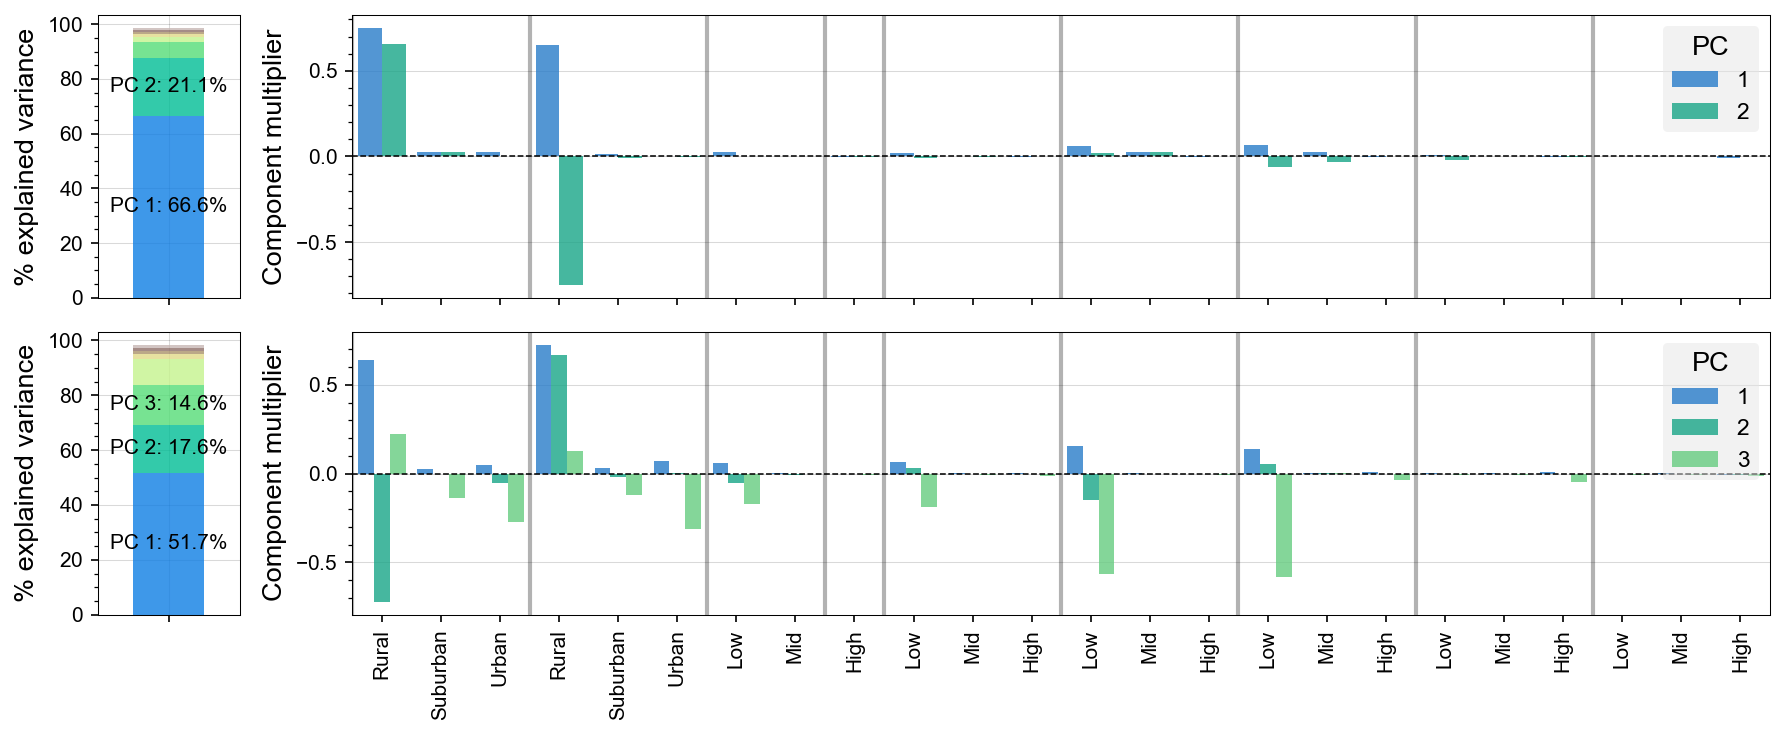

In [10]:
def plot_pca_contrib(cols, ncomps, shaps=shap_level, trips=trips,
                     size=(12, 5), dpi=150, cmap='terrain', rotation=90):
    df, ncol = trips[cols], len(cols)
    cols = list(pd.get_dummies(df, prefix_sep='__').columns)
    fig, axes = plt.subplots(2, 2, figsize=size, dpi=dpi,
                             gridspec_kw=D(width_ratios=[1, 10]))
    for i, (target, ncomp) in enumerate(ncomps.items()):
        X = shaps.query(f'target=="{target}"')[cols]
        pca = PCA(ncol).fit(X)
        ## Panel A: Explained variance ratios
        contrib = pca.explained_variance_ratio_ * 100
        df = Pdf(D(val=contrib))
        ax = pplot(axes[i, 0], ylab='% explained variance')
        colors = sns.color_palette(cmap, ncol)
        ax = df.T.plot(ax=ax, kind='bar', stacked=True, color=colors, alpha=0.8)
        df['pos'] = (df.val.cumsum() + df.val.cumsum().shift().fillna(0)) / 2
        for _, r in df.iloc[:ncomp].iterrows():
            ax.text(0, r.pos, f'PC {r.name + 1}: {r.val:.1f}%', ha='center', va='center')
        ax.get_legend().remove()
        ax.set_xticklabels([])
        ## Panel B: Individual component multipliers
        df = Pdf(pca.components_[:ncomp, :].T).assign(col=X.columns)
        df = df.melt('col', var_name='PC', value_name='mult')
        df.PC += 1
        ax = pplot(axes[i, 1], xminor=0)
        sns.barplot(df, ax=ax, x='col', y='mult', hue='PC', palette=colors[:ncomp], alpha=0.8)
        ax.axhline(0, ls='--', color='k', lw=0.75)
        ax.set_ylabel('Component multiplier')
        ax.set_xlabel('')
        df = Pdf(D(col=X.columns, feat=[x.split('__')[0] for x in X.columns]))
        for x in list(df.feat.drop_duplicates().index) + [ncol]:
            ax.axvline(x - 0.5, color='k', alpha=0.3, lw=2)
        ax.set_xticklabels([x.split('__')[1] for x in X.columns] if i == 1 else [], rotation=rotation)
    plt.tight_layout()


od_cols = [x for x in feature_grps.query('group=="OD"').feature if x not in ['MSAKind']]
x = plot_pca_contrib(od_cols, D(Duration=2, LogDistance=3), rotation=90, dpi=150); x

In [11]:
def combine_od_vars(trips=trips, cols=['Urban', 'PopDensity', 'HouseDensity', 'EmpDensity']):
    cols = sum([[x + y for y in 'OD'] for x in cols], [])
    df = trips[cols].apply(lambda x: x.cat.codes)
    x = pd.cut(df.mean(1), [-1, 0.67, 1.33, 3], labels=['Low', 'Mid', 'High'])
    df = pd.concat([trips[['Duration', 'LogDistance', 'Speed']], Pdf(D(density=x))], axis=1)
    _, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
    for i, (trg, rng, bw) in enumerate([
            ('LogDistance', (2, 5), 1),
            ('Duration', (0, 90), 2),
            ('Speed', (0, 80), 1)]):
        ax = pplot(axes[i], xlab=trg, ylab='Probability density' if i == 0 else '')
        sns.kdeplot(df, ax=ax, x=trg, hue='density', bw_adjust=bw, clip=rng)
    plt.tight_layout()

# x = combine_od_vars(); x

## 3.4. SES

/tmp/ipykernel_103880/4169685953.py:33: UserWarning:

FixedFormatter should only be used together with FixedLocator



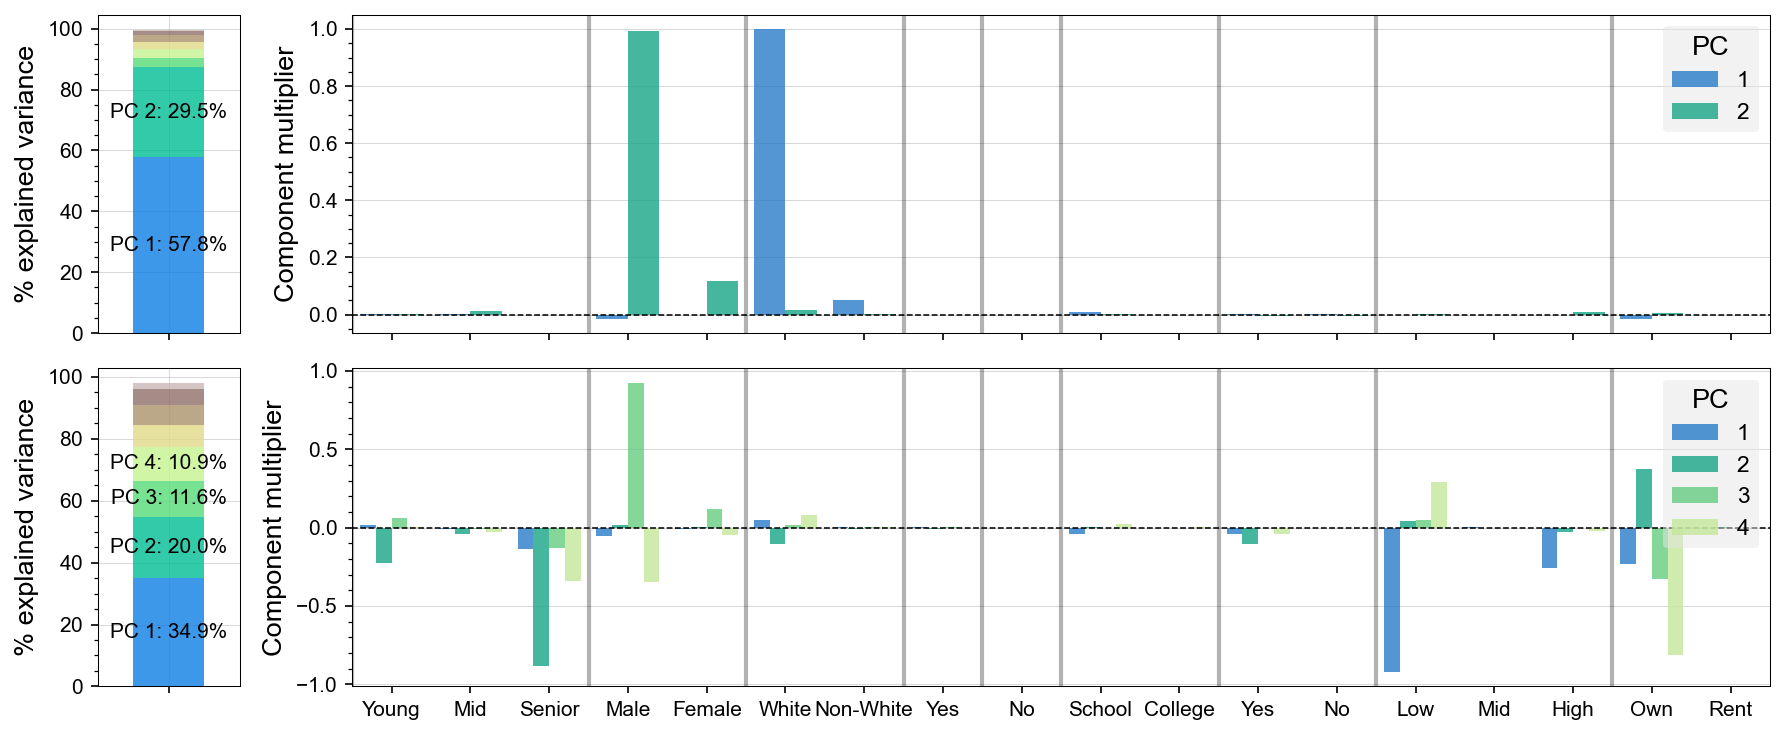

In [17]:
ses_cols = feature_grps.query('group=="SES"').feature
x = plot_pca_contrib(ses_cols, D(Duration=2, LogDistance=4), rotation=0, dpi=150); x

In [13]:
def shap_ses(shaps=shap_level, groups=feature_grps, top=5):
    X = pd.concat([shaps.filter(like=f + '__') for f in 
                   groups.query('group=="SES"').feature], axis=1)
    for target, df in pd.concat([shaps.target, X], axis=1).groupby('target'):
        imp = np.abs(df.iloc[:, 1:]).mean().sort_values(ascending=False)
        imp = Series({k.replace('__', ': '): v for k, v in 
                      imp.head(top).items()} | D(Other=imp.iloc[top:].sum()))
        return imp
    return imp

x = shap_ses(); x

Race: White     0.003707
Sex: Male       0.003426
Worker: Yes     0.000710
Income: High    0.000630
HomeOwn: Own    0.000619
Other           0.002455
dtype: float64

In [14]:
def fig_pca_ses_duration(trips=trips, shaps=shap_level, groups=feature_grps,
                         size=(12, 4), dpi=150):
    shaps = shaps.query('target=="Duration"')
    X = pd.concat([shaps.filter(like=f + '__') for f in 
                   groups.query('group=="SES"').feature], axis=1)
    pca = PCA(X.shape[1]).fit(X)
    X2 = Pdf(pca.transform(X)[:, :2])
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    colors = sns.color_palette('pastel', pca.n_components_)[:-1] + ['darkgrey']
    vals = pca.explained_variance_ratio_
    vals = list(vals[:2]) + [vals[2:].sum()]
    labels = [f'{x}\n({y * 100:.1f}%)' for x, y in zip(
        ['PC1', 'PC2', f'Other {len(vals) - 2}'], vals)]
    axes[0].pie(vals, labels=labels, colors=colors,
                labeldistance=0.5, startangle=90, textprops=D(ha='center'))
    for i, feat in enumerate(['Race', 'Sex']):
        ax = pplot(axes[i + 1], xlab='PC1', ylab='PC2')
        df = pd.concat([X2, trips[feat].rename('cat')], axis=1)
        colors = dict(zip(df.cat.categories, ['tomato', 'royalblue']))
        df['color'] = df.cat.map(colors)
        ax.scatter(df[0], df[1], c=df.color, s=2, alpha=0.5)
        ax.legend(loc='upper right', handles=[
            mpl.lines.Line2D([0], [0], marker='o', markerfacecolor=color,
                             markeredgecolor='none', lw=0, label=label)
            for label, color in colors.items()])
        for func in [ax.axvline, ax.axhline]:
            func(0, color='k', ls='--', lw=1)
        if i > 0: ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0.2)
    imsave('PCA of duration wrt SES factors', root='../fig/nhts')

# fig_pca_ses_duration(dpi=250) # t=0:59

In [15]:
def plot_ses_distr(trips=trips, target='Duration', xcols=['Race', 'Sex'],
                   rng=(0, 90), size=(4, 3), dpi=150):
    ax = pplot(size=size, dpi=dpi, xlim=rng)
    for cols, df in trips.groupby(xcols):
        sns.kdeplot(df, x=target, bw_adjust=2, ax=ax, clip=rng,
                    lw=1, label=(' '.join(cols).title() + 
                                 ' (n=%.1fk)' % (len(df) / 1e3)))
    ax.set_xlabel('Trip duration (min)')
    ax.set_ylabel('Probability density')
    ax.set_xticks(np.arange(0, 91, 15))
    ax.legend()

# plot_ses_distr()

  0%|          | 0/5 [00:00<?, ?it/s]

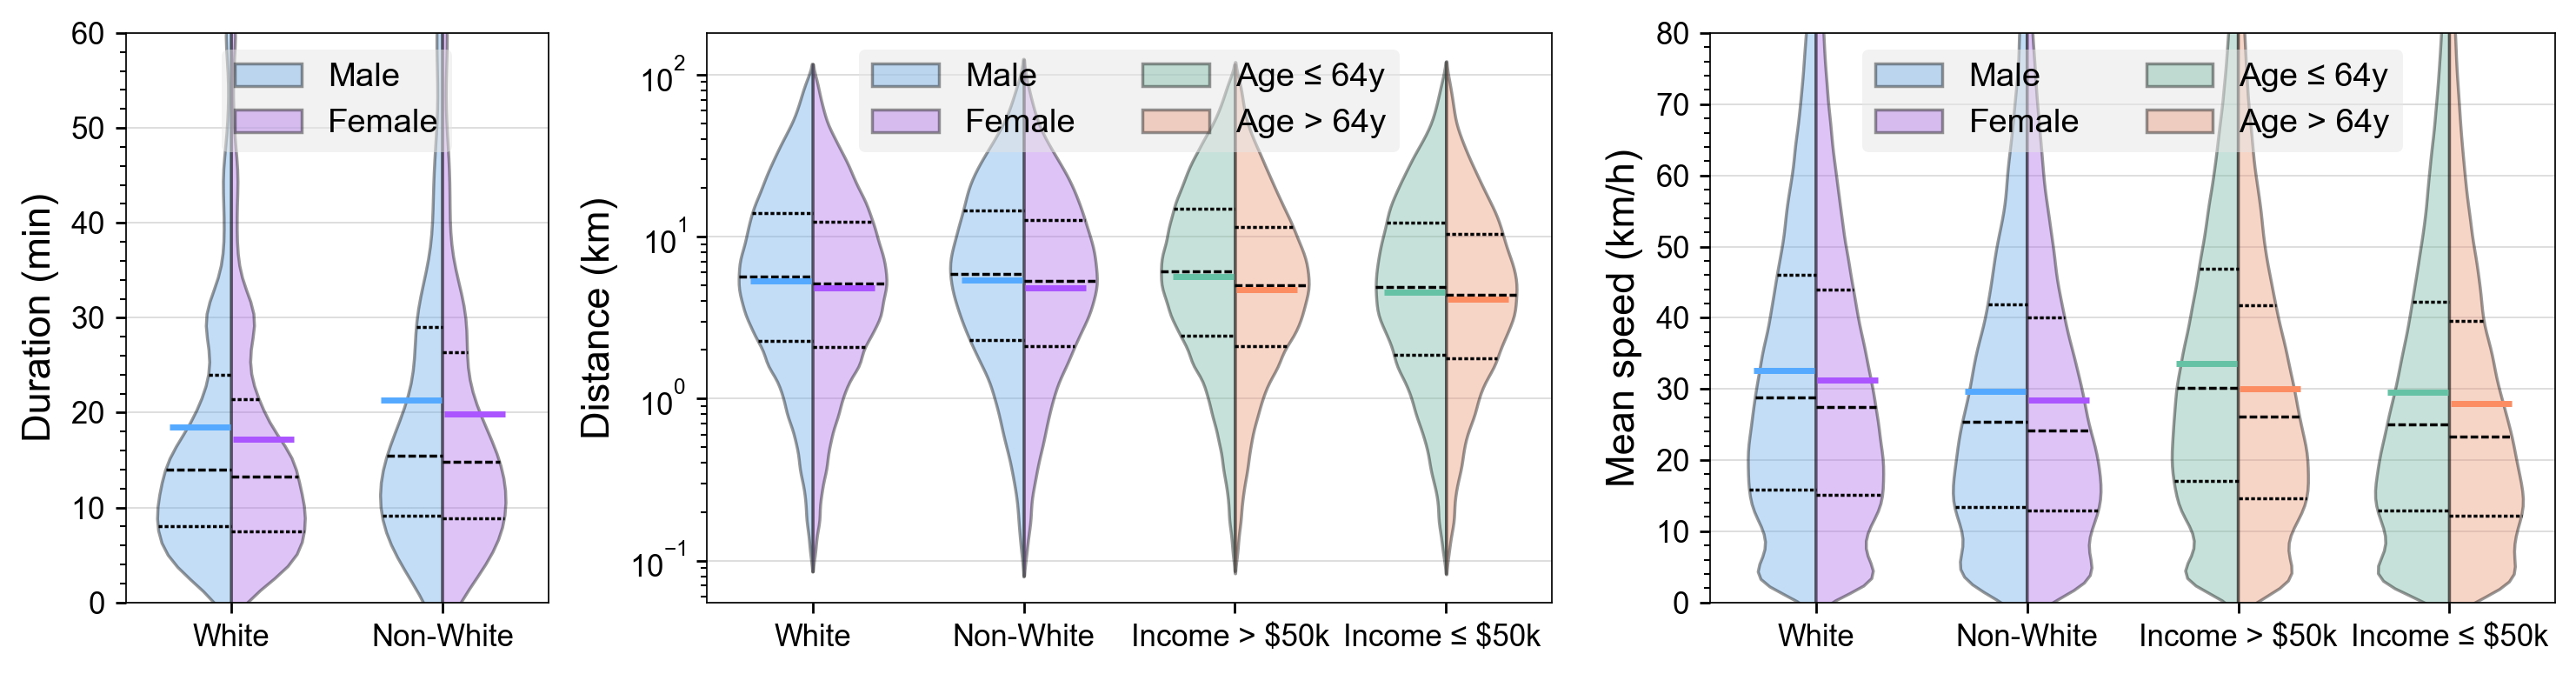

In [23]:
def fig_det_distr_by_ses(trips=trips, size=(12, 3.2), dpi=150):
    df = trips.query('2 <= LogDistance <= 5').copy()
    df.Income = df.Income.map(D(Low='Income ≤ $50k', Mid='Income > $50k', High='Income > $50k'))
    df['Income2'] = df.Income.astype(str) + ' '
    cats = ['Age ≤ 64y', 'Age > 64y']
    df.Age = (df.Age.map(D(Young=cats[0], Mid=cats[0], Senior=cats[1]))
              .astype(CAT).cat.reorder_categories(cats, True))
    fig, axes = plt.subplots(1, 3, figsize=size, dpi=dpi,
                             gridspec_kw=D(width_ratios=[0.5, 1, 1]))
    pbar = tqdm(range(5))
    def violin(ax, y, x, hue, cmap, bw=1, **kw):
        pbar.update()
        ax = pplot(ax, **kw)
        ax = sns.violinplot(df, ax=ax, x=x, y=y, hue=hue, palette=cmap,
                            bw_adjust=bw, cut=1.2, inner='quart', width=0.7,
                            edgecolor='k', linewidth=1, alpha=0.4, split=1)
        return sns.pointplot(df, ax=ax, x=x, y=y, hue=hue, palette=cmap,
                             errorbar=None, dodge=0.3, linestyle='none', legend=False,
                             marker='_', markersize=20, markeredgewidth=2)
    ## Duration
    ax = violin(axes[0], 'Duration', x='Race', hue='Sex', cmap='cool', bw=2)
    ax = pplot(ax, ylim=(0, 60), ylab='Duration (min)', xminor=0)
    ## Distance
    ax = violin(axes[1], 'Distance', x='Race', hue='Sex', cmap='cool', bw=1.2, ylog=1)
    ax = violin(ax, 'Distance', x='Income2', hue='Age', cmap='Set2', bw=1.2, ylog=1)
    ax = pplot(ax, ylab='Distance (km)', xminor=0)
    ## Speed
    ax = violin(axes[2], 'Speed', x='Race', hue='Sex', cmap='cool')
    ax = violin(ax, 'Speed', x='Income', hue='Age', cmap='Set2')
    ax = pplot(ax, ylim=(0, 80), ylab='Mean speed (km/h)', xminor=0)
    for ax, ncol in zip(axes, [1, 2, 2]):
        ax.legend_.set_title('')
        ax.legend(loc='upper center', ncol=ncol)
    fig.tight_layout()

x = fig_det_distr_by_ses(dpi=250); x # t=0:23

## 3.5. Distributions of finalized features

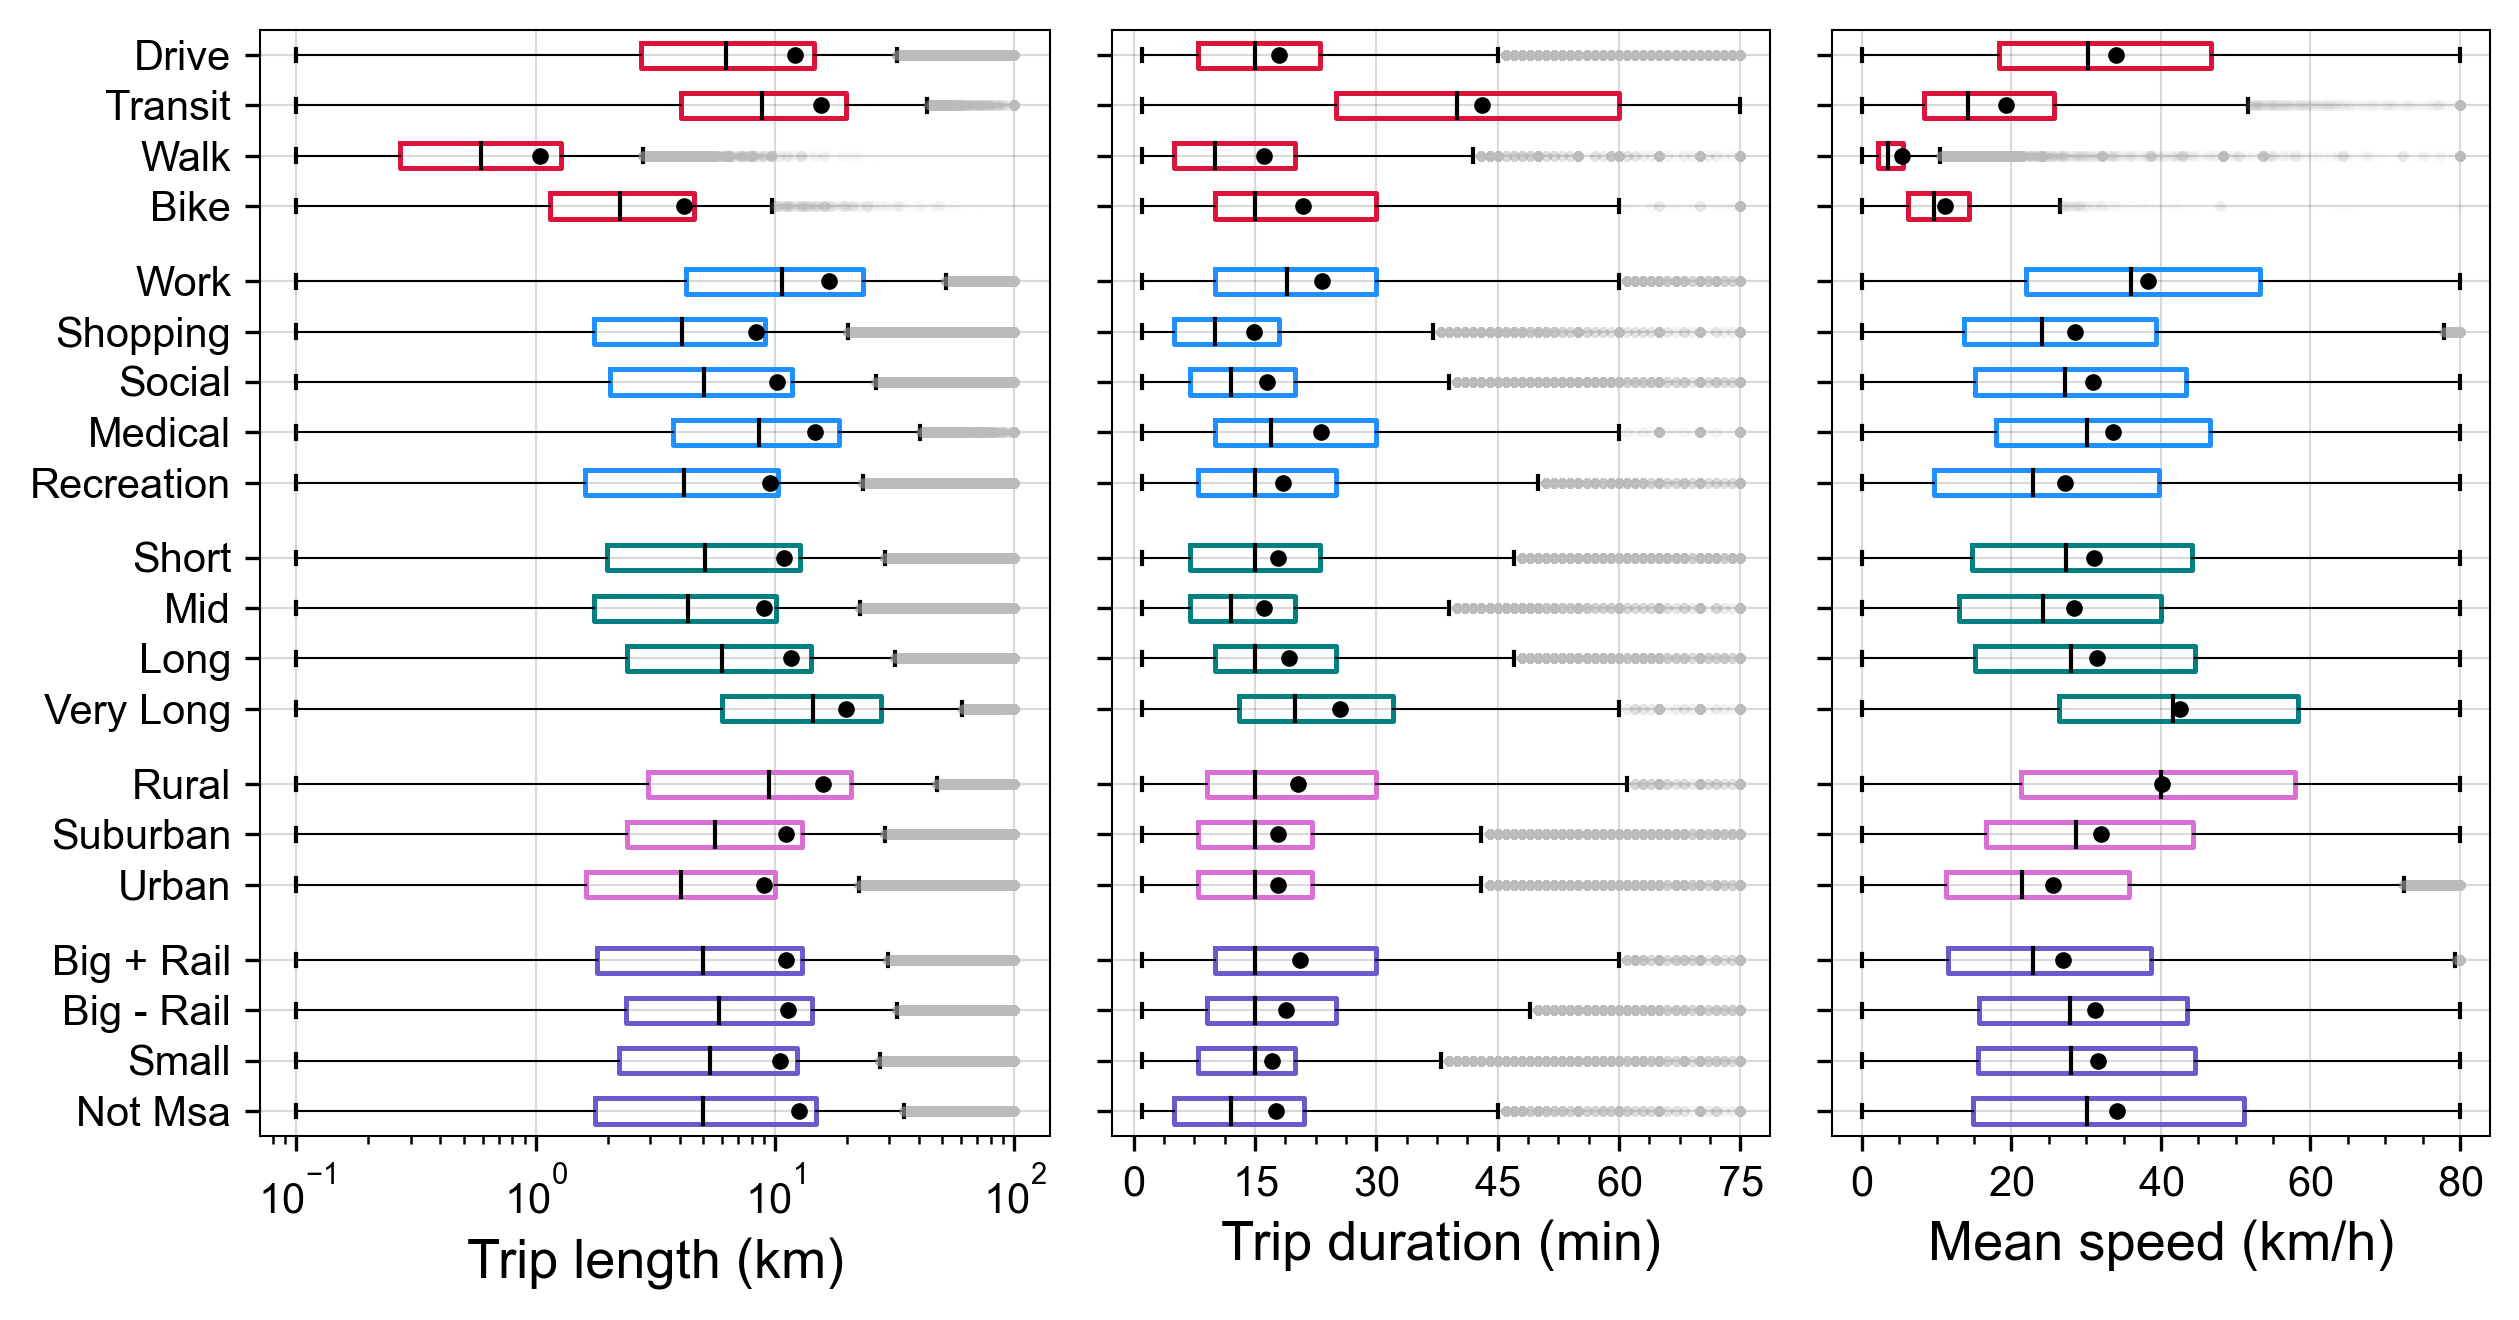

In [ ]:
def plot_distr_box(trips=trips, size=(8.5, 4.5), dpi=150):
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    cols = D(Mode='crimson', Purpose='dodgerblue',
            #  StartTime='limegreen',
             StayTime='teal',
            #  Sex='darkgoldenrod', Race='olivedrab', Income='darkorange',
             UrbanO='orchid', MSAKind='slateblue')
    ticker = mpl.ticker.EngFormatter(places=1)
    for j, (var, label, rng) in enumerate([
            ('Distance', 'Trip length (km)', (0.1, 100)),
            ('Duration', 'Trip duration (min)', (0, 75)),
            ('Speed', 'Mean speed (km/h)', (0, 80))]):
        df = Pdf(sum([[D(col=col, cat=x[0].title().replace('_', ' '),
                         vals=x[1].values, pos=i / 2, n=ticker(len(x[1]))) 
                       for x in trips.groupby(col)[var]]
                      for i, col in enumerate(cols.keys())], []))
        df.vals = [x.clip(*rng) for x in df.vals]
        df['color'] = df.col.map(cols)
        ax = pplot(axes[j], xlog=var == 'Distance', xlab=label)
        x = ax.boxplot(
            df.vals, positions=df.pos + df.index, labels=df.cat,
            vert=False, whiskerprops=D(lw=0.5), boxprops=D(lw=1.2),
            flierprops=D(markersize=1.5, markeredgecolor='#bbb', alpha=0.01),
            showmeans=True, meanline=False, medianprops=D(color='k'),
            meanprops=D(markersize=4, markeredgecolor='none',
                        marker='o', markerfacecolor='k'))
        for box, color in zip(x['boxes'], df.color):
            box.set_color(color)
        ax.tick_params(which='minor', left=False)
        ax.invert_yaxis()
        if var == 'Duration': ax.set_xticks(np.arange(0, 75+1, 15))
        if j != 0: ax.set_yticklabels([])
    plt.tight_layout()
    imsave('Deterrence distribution by NHTS field', root='../fig/nhts')

plot_distr_box(dpi=300) # t=0:07

In [ ]:
def plot_distr_box(trips=trips, size=(8.5, 12.5), dpi=150, cmap='prism'):
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    ticker = mpl.ticker.EngFormatter(places=1)
    for j, (trg, label, rng) in enumerate([
            ('Distance', 'Trip length (km)', (0.1, 100)),
            ('Duration', 'Trip duration (min)', (0, 60)),
            ('Speed', 'Mean speed (km/h)', (0, 80))]):
        cols = trips.select_dtypes(CAT).columns
        df = Pdf(sum([[D(col=col, pos=i / 2,
                         cat=col + ': ' + cat.replace('_', ' '),
                         vals=df[trg].values, n=ticker(len(df)),
                         color=sns.color_palette(cmap, len(cols))[i])
                       for cat, df in trips.groupby(col)]
                      for i, col in enumerate(cols)], []))
        df.vals = [x.clip(*rng) for x in df.vals]
        ax = pplot(axes[j], xlog=trg == 'Distance', xlab=label)
        x = ax.boxplot(
            df.vals, positions=df.pos + df.index, labels=df.cat,
            vert=False, whiskerprops=D(lw=0.5), boxprops=D(lw=1.2),
            flierprops=D(markersize=1.5, markeredgecolor='#bbb', alpha=0.01),
            showmeans=True, meanline=False, medianprops=D(color='k'),
            meanprops=D(markersize=4, markeredgecolor='none',
                        marker='o', markerfacecolor='k'))
        for box, color in zip(x['boxes'], df.color):
            box.set_color(color)
        ax.tick_params(which='minor', left=False)
        ax.invert_yaxis()
        if trg == 'Duration': ax.set_xticks(np.arange(0, 61, 15))
        if j != 0: ax.set_yticklabels([])
    plt.tight_layout()
    title = 'Deterrence distribution for all variables by NHTS field'
    imsave(title, root='../fig/nhts')

# x = plot_distr_box(dpi=300); x # t=0:33